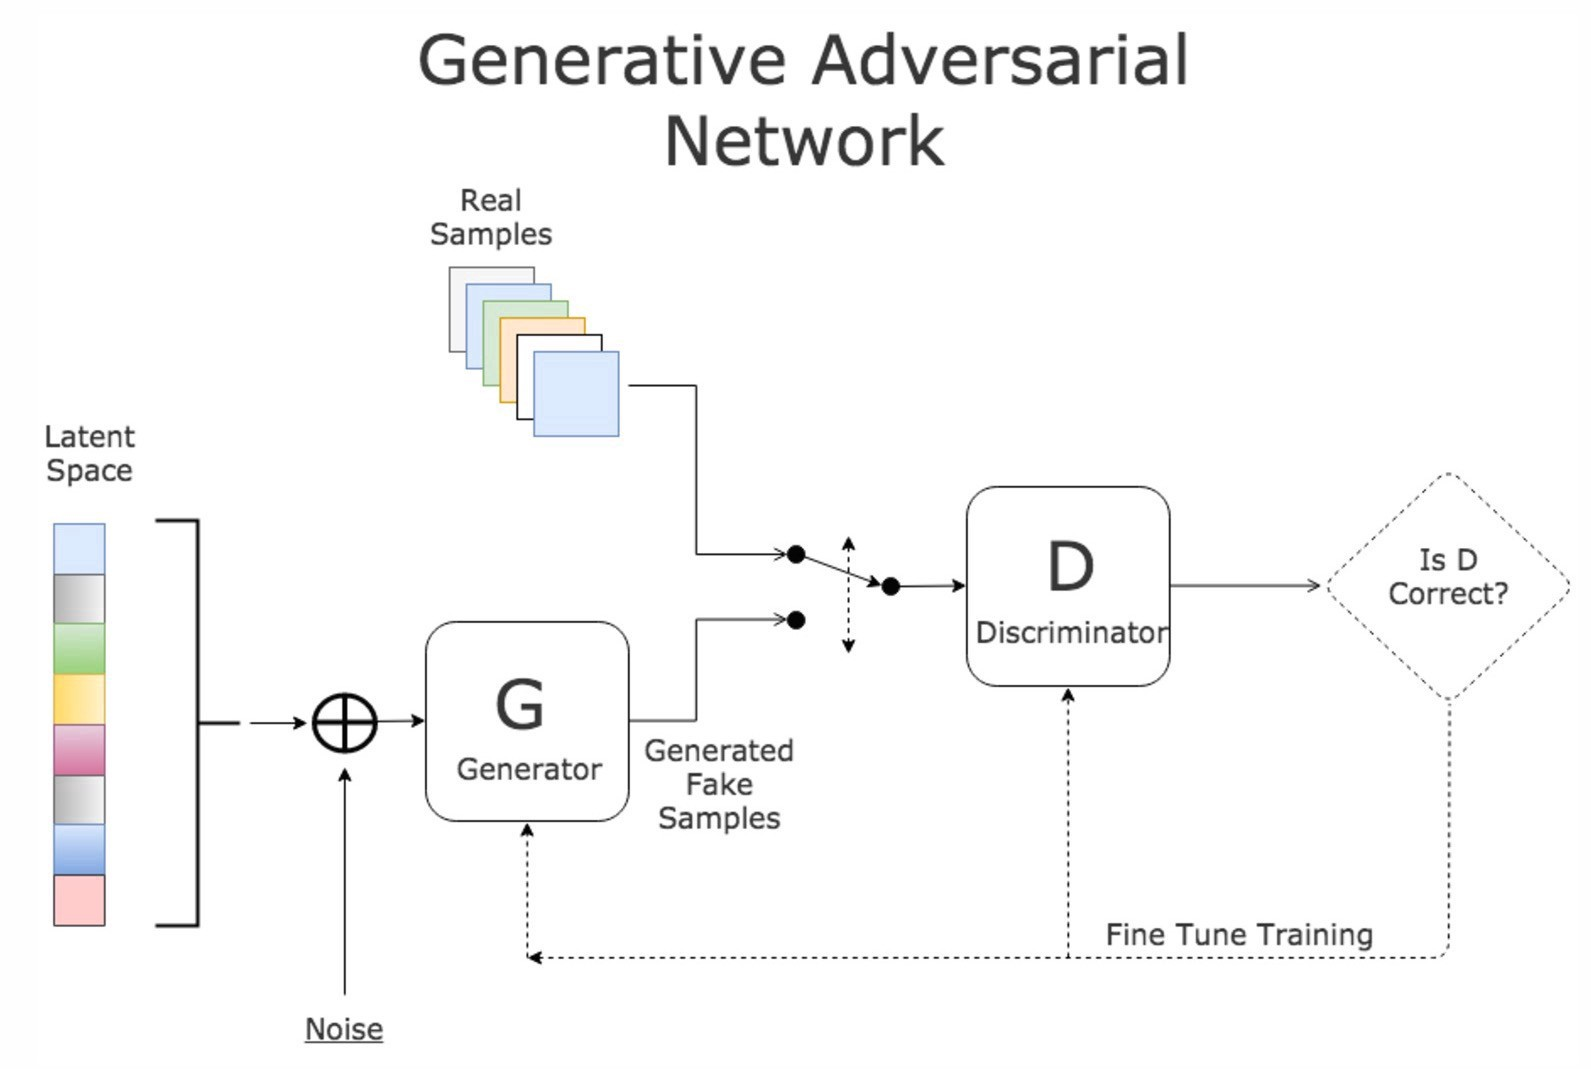

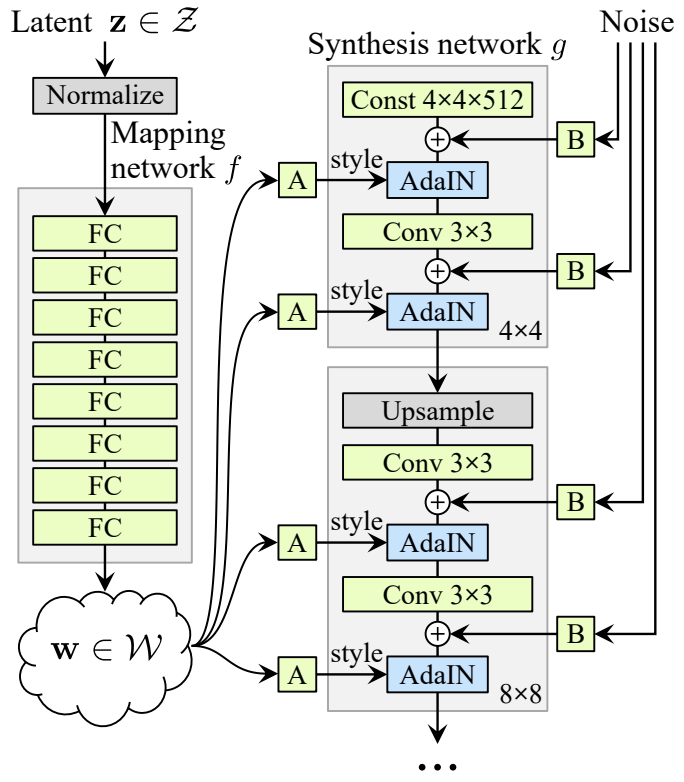

#0. Set-Up (Run only once!)
Clone Repo and extract contents

In [ ]:
!git clone https://github.com/laoyita/StyleGan2_FaceMorphing.git


In [ ]:
cd StyleGan2_FaceMorphing

In [ ]:
mkdir my_aligned_imgs my_imgs

In [ ]:
# These Python packages are the only thing missing from Gradient Paperspace's TensorFlow 1.14 container!
!pip install requests
!pip install Pillow
!pip install tqdm
!pip install dlib
!pip install tensorflow==1.14
!pip install tensorflow-gpu==1.14

# 1. A Quick Review of **GANs**

In [ ]:
#collapse-hide
import sys
sys.path.append('stylegan2/')

from stylegan2 import pretrained_networks
from stylegan2 import dnnlib
from stylegan2.dnnlib import tflib

from pathlib import Path
from PIL import Image
import pickle
import numpy as np

import ipywidgets as widgets
from tqdm import tqdm

model_path = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
fps = 20
results_size = 400

In [ ]:
#collapse-hide

# Code to load the StyleGAN2 Model
def load_model():
    _G, _D, Gs = pretrained_networks.load_networks(model_path)
    
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
    
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    
    return Gs, noise_vars, Gs_kwargs

# Generate images given a random seed (Integer)
def generate_image_random(rand_seed):
    rnd = np.random.RandomState(rand_seed)
    z = rnd.randn(1, *Gs.input_shape[1:])
    tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars})
    images = Gs.run(z, None, **Gs_kwargs)
    return images, z

# Generate images given a latent code ( vector of size [1, 512] )
def generate_image_from_z(z):
    images = Gs.run(z, None, **Gs_kwargs)
    return images

In [ ]:
# Loading the StyleGAN2 Model!
Gs, noise_vars, Gs_kwargs = load_model()

In [ ]:
# Ask the generator to make an output, given a random seed number: 42
images, latent_code1 = generate_image_random(40)
image1 = Image.fromarray(images[0]).resize((results_size, results_size))
latent_code1.shape

In [ ]:
image1

In [ ]:
# Ask the generator to make an output, given a random seed number: 1234
images, latent_code2 = generate_image_random(123)
image2 = Image.fromarray(images[0]).resize((results_size, results_size))
latent_code2.shape

In [ ]:
latent_code1[0][:5], latent_code2[0][:5]

In [ ]:
image2


In [ ]:
def linear_interpolate(code1, code2, alpha):
    return code1 * alpha + code2 * (1 - alpha)
interpolated_latent_code = linear_interpolate(latent_code1, latent_code2, 0.5)
interpolated_latent_code.shape

In [ ]:
images = generate_image_from_z(interpolated_latent_code)
Image.fromarray(images[0]).resize((results_size, results_size))


Let's also make a cool interpolation animation; It'll help with visualizing the effect of interpolating from alpha=0 to alpha=1

In [ ]:
#collapse-hide
output_gifs_path = Path('output_gifs')
# Make Output Gifs folder if it doesn't exist.
if not output_gifs_path.exists():
    output_gifs_path.mkdir()

In [ ]:
#collapse-hide
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def make_latent_interp_animation(code1, code2, img1, img2, num_interps):
    
    step_size = 1.0/num_interps
    
    all_imgs = []
    
    amounts = np.arange(0, 1, step_size)
    
    for alpha in tqdm(amounts):
        interpolated_latent_code = linear_interpolate(code1, code2, alpha)
        images = generate_image_from_z(interpolated_latent_code)
        interp_latent_image = Image.fromarray(images[0]).resize((400, 400))
        frame = get_concat_h(img1, interp_latent_image)
        frame = get_concat_h(frame, img2)
        all_imgs.append(frame)

    save_name = output_gifs_path/'latent_space_traversal.gif'
    all_imgs[0].save(save_name, save_all=True, append_images=all_imgs[1:], duration=1000/fps, loop=0)

In [ ]:
make_latent_interp_animation(latent_code1, latent_code2, image1, image2, num_interps=200)

the interpolation gif will be saved in the following location: output_gifs/latent_space_traversal.gif :)

# Facial Image Alignment using Landmark Detection
Ok so this is all fun and stuff right? How could we play around with our own images, instead of random people that don't exist?

Well, we first have to project our own images into this latent space.

 Important: The first step of projecting our own images is to make sure that they are representative of the training data. StyleGAN2 was trained on the FFHQ Dataset. More specifically, the images used during training were actually aligned first, before giving it to the discriminator in StyleGAN2.
 
To align (normalize) our images for StyleGAN2, we need to use a landmark detection model. This will automatically find the facial keypoints of interest, and crop/rotate accordingly.
At this point, if you want to run this with your own images, all you need to do is go to the imgs/ folder, and delete the example images, Jeremy_Howard.jpg and Obama.jpg. Then upload 2 of your own!

In [ ]:
#collapse-hide
#orig_img_path = Path('imgs')
#aligned_imgs_path = Path('aligned_imgs')

orig_img_path = Path('my_imgs')
aligned_imgs_path = Path('my_aligned_imgs')

if not orig_img_path.exists():
    orig_img_path.mkdir()

# Make Aligned Images folder if it doesn't exist.
if not aligned_imgs_path.exists():
    aligned_imgs_path.mkdir()
    
orig_img_path, aligned_imgs_path

In [ ]:
# One-Time Download of Facial Landmark Detection Model Weights
if not Path('shape_predictor_68_face_landmarks.dat').exists():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dv shape_predictor_68_face_landmarks.dat.bz2

In [ ]:
from align_face import align_face

# Align all of our images using a landmark detection model!
all_imgs = list(orig_img_path.iterdir())
for img in all_imgs:
    align_face(str(img)).save(aligned_imgs_path/('aligned_'+img.name))

Let's load the original + aligned images into Jupyter!

In [ ]:
#collapse-hide
aligned_img_set = list(aligned_imgs_path.iterdir())
aligned_img_set.sort()
aligned_img_set = [Image.open(x) for x in aligned_img_set]

orig_img_set = list(orig_img_path.iterdir())
orig_img_set.sort()
orig_img_set = [Image.open(x) for x in orig_img_set]

In [ ]:
get_concat_h(orig_img_set[0], aligned_img_set[0])

In [ ]:
get_concat_h(orig_img_set[1], aligned_img_set[1])

# Projecting our own Input Images into the Latent Space

Warning: At this point, I restarted my notebook kernel to clear my GPU card memory. The previous sections loaded models inside our notebook, so I ended up restarting the kernel to free space. This is recommended because the next section will be invoking official stylegan2 python scripts from inside notebook cells, and they load models interally (separately from this notebook). You’ll most likely run out of GPU memory if you don’t restart! Everything in this notebook will still run nicely from top-to-bottom, don’t worry!

You can either manually restart your kernel by going to Kernel -> Restart, or run the below cell:

In [ ]:
#collapse-show
# Automatically restart the kernel by running this cell
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
#collapse-hide
import sys
sys.path.append('stylegan2/')

from stylegan2 import pretrained_networks
from stylegan2 import dnnlib
from stylegan2.dnnlib import tflib

from pathlib import Path
from PIL import Image
import pickle
import numpy as np

import ipywidgets as widgets
from tqdm import tqdm

model_path = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
fps = 20
results_size = 400

First, we’ll make an official stylegan2 compatible dataset, to ignore the warnings from deprecated TensorFlow 1.14, we use the -W ignore option when executing python on the command line.

In [ ]:
!python -W ignore stylegan2/dataset_tool.py create_from_images datasets_stylegan2/custom_imgs my_aligned_imgs/

Now let’s project our previously aligned images into the latent space, and get those latent codes that will hopefully well-represent the images.

Some things to explain here:

Projecting an image into the latent space basically means: Let's figure out what latent code (512 numbers) will cause the generator to make an output that looks like our image
The question is, how do we figure out the latent code? With VAEs (variational autoencoder), we just throw our image through the encoder and we get our latent code just like that!
With GANs, we don't necessarily have a direct way to extract latent codes from an input image, but we can optimize for it.
In a nut shell, here's how we can optimize for a latent code for given input images:
For as many iterations as you'd like, do:

Ask the generator to generate some output from a starting latent vector.
Take the generator's output image, and take your target image, put them both through a VGG16 model (image feature extractor).
Take the generator's output image features from the VGG16.
Take the target image features from the VGG16.
Compute the loss on the difference of features!
Backprop
 Important: Note that the loss between the generator’s output image, and the target image, is in the feature space of a VGG16! Why? If we performed pixel-wise loss on just the raw image pixels, it won’t account for any facial features, just color of pixels. Checking the difference of features allows us to optimize for a latent code that doesn’t just check for pixel values, but also the patterns in the pixels that correspond to high-level features, such as cheekbones, eyebrows, nose size, eye width, smile, etc.

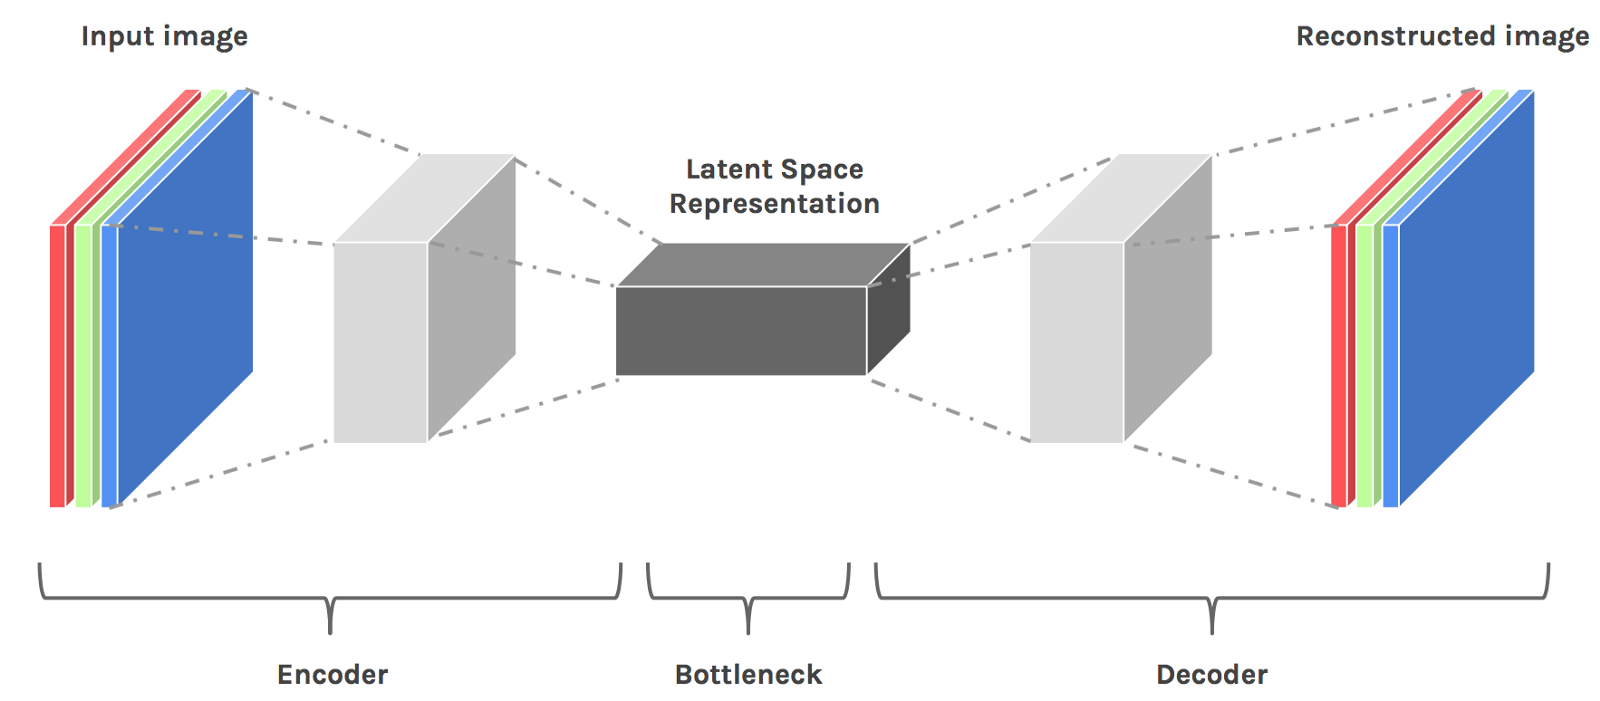

In [ ]:
tot_aligned_imgs = 2
output_gifs_path = Path('output_gifs')
# Make Output Gifs folder if it doesn't exist.
if not output_gifs_path.exists():
    output_gifs_path.mkdir()

# !!!! Following cell will take 20 minutes in Colab (GPU) !!!

In [ ]:
!python -W ignore stylegan2/epoching_custom_run_projector.py project-real-images --network=$model_path \
  --dataset=custom_imgs --data-dir=datasets_stylegan2 --num-images=$tot_aligned_imgs --num-snapshots 500

In [ ]:
#collapse-hide
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def make_project_progress_gifs():
    
    all_result_folders = list(Path('results/').iterdir())
    all_result_folders.sort()

    last_result_folder = all_result_folders[-1]
    
    for img_num in range(tot_aligned_imgs):
        all_step_pngs = [x for x in last_result_folder.iterdir() if x.name.endswith('png') and 'image{0:04d}'.format(img_num) in x.name]
        all_step_pngs.sort()

        target_image = Image.open(all_step_pngs[-1]).resize((results_size, results_size))

        all_concat_imgs = []
        for step_img_path in all_step_pngs[:-1]:
            step_img = Image.open(step_img_path).resize((results_size, results_size))
            all_concat_imgs.append(get_concat_h(target_image, step_img))

        all_concat_imgs[0].save('output_gifs/image{0:04d}_project_progress.gif'.format(img_num), save_all=True, append_images=all_concat_imgs[1:], duration=1000/fps, loop=0)

In [ ]:
make_project_progress_gifs()

the project progress gifs will be saved in output_gifs/image####_project_progress.gif :)

Let's look at the optimized latent codes we have acquired through this projection process!

In [ ]:
#collapse-hide
def get_final_latents():
    all_results = list(Path('results/').iterdir())
    all_results.sort()
    
    last_result = all_results[-1]

    latent_files = [x for x in last_result.iterdir() if 'final_latent_code' in x.name]
    latent_files.sort()
    
    all_final_latents = []
    
    for file in latent_files:
        with open(file, mode='rb') as latent_pickle:
            all_final_latents.append(pickle.load(latent_pickle))
    
    return all_final_latents

In [ ]:
latent_codes = get_final_latents()
len(latent_codes), latent_codes[0].shape, latent_codes[1].shape

Note: We now have two latent codes for our Jeremy Howard and Obama images! Notice how these codes are of the shape (1, 18, 512), instead of the (1, 512) shape we saw earlier on the generated (fake) examples. This is due to one of the architecture designs of StyleGAN2, it actually re-iterates the base latent vector at different levels in the generator to allow for small deviations in the latent code to support variance in style. During training, just one static latent vector of the shape (1, 512) is used. For a more detailed explanation, check out the recommended technical StyleGAN2 overview blog posts mentioned in the introduction! :)

Let's check out what our images look like from our latent codes!

In [ ]:
#collapse-hide
def load_model():
    _G, _D, Gs = pretrained_networks.load_networks(model_path)
    
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
    
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    
    return Gs, noise_vars, Gs_kwargs

def generate_image_from_projected_latents(latent_vector):
    images = Gs.components.synthesis.run(latent_vector, **Gs_kwargs)
    return images

In [ ]:
# Loading the StyleGAN2 Model!
Gs, noise_vars, Gs_kwargs = load_model()

In [ ]:
#collapse-hide
# Must re-define these variables because we restarted our kernel!
output_gifs_path = Path('output_gifs/')
aligned_imgs_path = Path('my_aligned_imgs/')
aligned_img_set = list(aligned_imgs_path.iterdir())
aligned_img_set.sort()
aligned_img_set = [Image.open(x) for x in aligned_img_set]

In [ ]:
# Ask the generator to make an output, given a latent code we found from the projection process.
images = generate_image_from_projected_latents(latent_codes[0])
recreated_img1 = Image.fromarray(images[0]).resize((results_size, results_size))

orig_img1 = aligned_img_set[1].resize((results_size, results_size))
get_concat_h(orig_img1, recreated_img1)

In [ ]:
# Ask the generator to make an output, given a latent code we found from the projection process.
images = generate_image_from_projected_latents(latent_codes[1])
recreated_img2 = Image.fromarray(images[0]).resize((results_size, results_size))

orig_img2 = aligned_img_set[0].resize((results_size, results_size))
get_concat_h(orig_img2, recreated_img2)

Now let's re-run the interpolation animation we did back in Section 4, but this time with our own projected latent codes!

In [ ]:
#collapse-hide
def linear_interpolate(code1, code2, alpha):
    return code1 * alpha + code2 * (1 - alpha)

def make_latent_interp_animation_real_faces(code1, code2, img1, img2, num_interps):
    
    step_size = 1.0/num_interps
    
    all_imgs = []
    
    amounts = np.arange(0, 1, step_size)
    
    for alpha in tqdm(amounts):
        interpolated_latent_code = linear_interpolate(code1, code2, alpha)
        images = generate_image_from_projected_latents(interpolated_latent_code)
        interp_latent_image = Image.fromarray(images[0]).resize((400, 400))
        frame = get_concat_h(img2, interp_latent_image)
        frame = get_concat_h(frame, img1)
        all_imgs.append(frame)

    save_name = output_gifs_path/'projected_latent_space_traversal.gif'
    all_imgs[0].save(save_name, save_all=True, append_images=all_imgs[1:], duration=1000/fps, loop=0)

In [ ]:
make_latent_interp_animation_real_faces(latent_codes[0], latent_codes[1], recreated_img1, recreated_img2, num_interps=200)

The interpolation gif will be saved in output_gifs/projected_latent_space_traversal.gif :)